# Image Segmentation

Image segmentation goes a step ahead of object detection in determining exact or rather pixel-level boundaries of each of the objects in the input image/video. 

Image segmentation tasks can be divided two main categories:

+ __Semantic Segmentation__: This is the base level segmentation task usually performed. This process classifies each pixel as belonging to a specific class. It does not differentiate between different instances of the same task. For instance, if an image has two cars, semantic segmentation will attribute the same label to all pixels of both the cars.
+ __Instance Segmentation__: As the name suggests, this task differentiates each instance of every class, i.e. it assigns a unique label to every instance of a particular object in the image. Continuing with the previous example itself, instance segmentation would identify each car as a separate instance of class car. This is usually done by assigning a different colour to each instance (along with the class label).


This notebook will make use of pretrained networks to build a U-Net architecture for segmentation



## Get Dataset 

+ Kaggle has a good list of datasets for image segmentation
+ Kaggle datasets can be accessed using Kaggle APIs
+ We will be using the Lyft-Udacity Challenge dataset in this notebook


In [ ]:
!pip install kaggle

In [ ]:
# copy kaggle creds to the required location
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# NOTE: Click on accept rules/late submission on kaggle to download the dataset
!kaggle datasets download -d kumaresanmanickavelu/lyft-udacity-challenge

100% 5.11G/5.11G [01:46<00:00, 35.0MB/s]
100% 5.11G/5.11G [01:46<00:00, 51.6MB/s]


In [ ]:
# NOTE: We only need dataA directory. You may only extract the required folder
!unzip lyft-udacity-challenge.zip

## Import Libraries

In [ ]:
import cv2
import os
import numpy as np
from glob import glob
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization,LeakyReLU
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf

In [ ]:
# Reusable components for up-sampling branch of U-Net
!pip install -q git+https://github.com/tensorflow/examples.git

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

## Prepare Dataset

+ Resize Image and Masks to fixed size
+ Normalize images by bringing them on a scale of [0,1]

In [ ]:
# Image Path
image_path = 'dataA/dataA/CameraRGB/'

# Mask Path
mask_path = 'dataA/dataA/CameraSeg/'

In [ ]:
image_list = os.listdir(image_path)
image_list = [image_path+i for i in image_list]
print("Total samples={}".format(len(image_list)))

Total samples=1000


In [ ]:
mask_list = os.listdir(mask_path)
mask_list = [mask_path+i for i in mask_list]

### View Sample File

[]

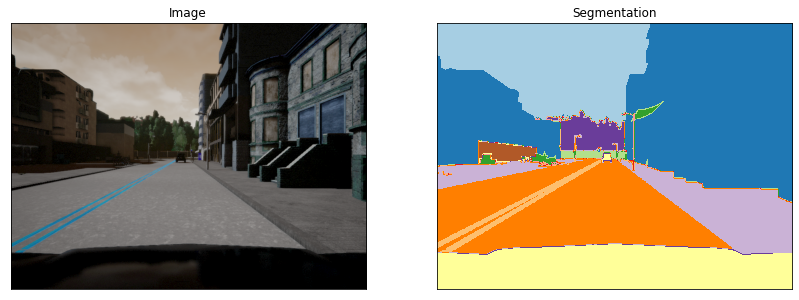

In [ ]:
N = np.random.randint(0,len(image_list))
img = cv2.imread(image_list[N])
mask = cv2.imread(mask_list[N])
mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) \
                 for j in range(mask.shape[1])]).reshape(img.shape[0], 
                                                         img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[0].set_xticks([])
arr[0].set_yticks([])

arr[1].imshow(mask, cmap='Paired')
arr[1].set_title('Segmentation');
arr[1].set_xticks([])
arr[1].set_yticks([])

### Utility Functions

In [ ]:
def prep_image(img):
  img = cv2.resize(img,(128,128))
  return img/ 255.0

In [ ]:
def prep_mask(input_mask):
  mask_img = cv2.resize(input_mask,(128,128))
  mask_img = mask_img[:,:,2]
  return mask_img

In [ ]:
# prepare images
image_list =  np.array([prep_image(cv2.imread(img)) for img in tqdm(image_list)])

In [ ]:
# prepare masks
mask_list =  np.array([prep_mask(cv2.imread(mask)) for mask in tqdm(mask_list)])
mask_list = mask_list.reshape((mask_list.shape[0], mask_list.shape[1], mask_list.shape[2], 1))

## Prepare U-Net
+ Down-sampling branch would be based on __MobileNetV2__ which is pretrained on ImageNetDataset
+ The down-sampling branch would help in feature extraction
+ Up-Sampling branch would use building blocks from TensorFlow library (pix2pix up-sampling blocks)
+ Only the up-sampling blocks will be trained while down-sampling layers would be frozen (__Transfer Learning to the rescue__)


In [ ]:
BATCH_SIZE = 64
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_CHANNELS = 3
EPOCHS = 100

In [ ]:
# get pre-trained model without final classification layer
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3],
                                               include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Downsampling branch for U-Net
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [ ]:
# Up-sampling layers
up_stack = [
    pix2pix.upsample(256, 3),  
    pix2pix.upsample(128, 3),  
    pix2pix.upsample(64, 3),  
    pix2pix.upsample(32, 3),   
]

### Utility function to prepare U-Net

In [ ]:
def unet_model(output_channels):
  """
  This function helps in connecting down-sampling and up-sampling branches.
  We also connect both branches using skip-connections.
  """
  inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last set of layers 
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')(x)  
  
  # These are added to handle instance segmentation
  # NOTE: Remove these and mask_out if semantic segmentation is the objective
  last = Conv2D(16, kernel_size = (1,1), padding = 'same')(last)
  last = LeakyReLU(0.2)(last)
  last = BatchNormalization()(last)

  # Output layer
  mask_out = Conv2D(13, (1,1), padding = 'same', 
                    activation = 'sigmoid', 
                    name = 'mask_out')(last)

  return tf.keras.Model(inputs=inputs, outputs=mask_out)

In [ ]:
# get model object and compile
model = unet_model(IMAGE_CHANNELS)
model.compile(optimizer=tf.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Visualize U-Net

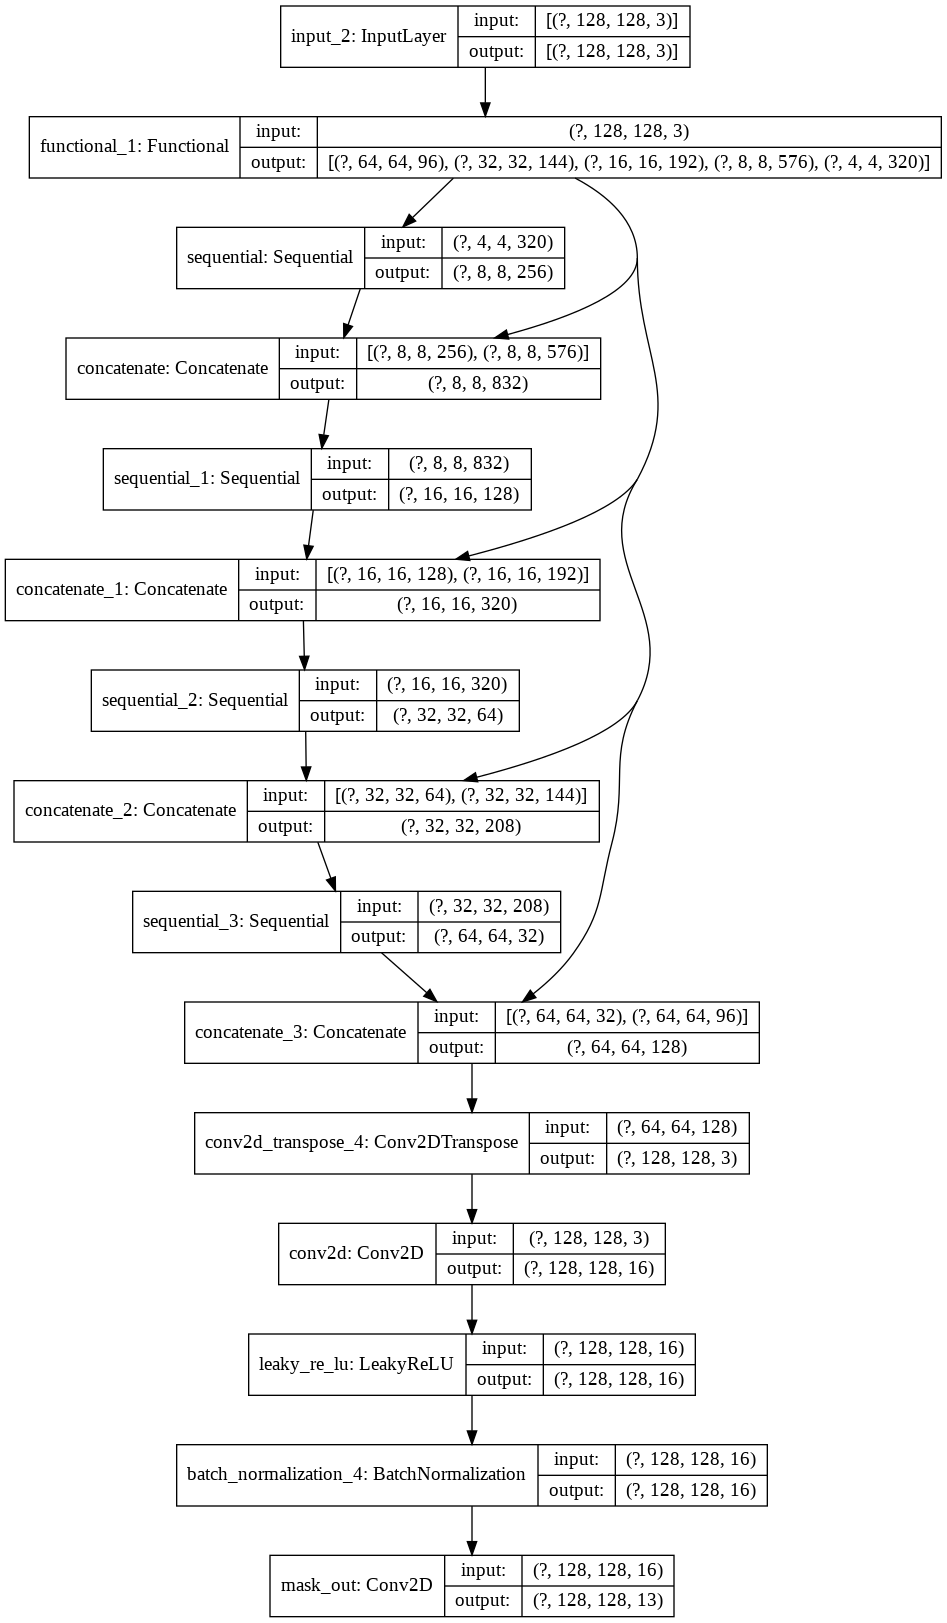

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Train the Model

In [ ]:
history = model.fit(image_list, 
                    mask_list, 
                    batch_size=BATCH_SIZE, 
                    epochs = EPOCHS, 
                    validation_split = 0.1)

Epoch 1/100
15/15 [==============================] - 3s 167ms/step - loss: 2.4882 - accuracy: 0.1069 - val_loss: 2.4960 - val_accuracy: 0.1383
Epoch 2/100
15/15 [==============================] - 1s 89ms/step - loss: 2.2467 - accuracy: 0.4037 - val_loss: 2.3790 - val_accuracy: 0.2527
Epoch 3/100
15/15 [==============================] - 1s 89ms/step - loss: 2.1181 - accuracy: 0.5607 - val_loss: 2.3196 - val_accuracy: 0.2596
Epoch 4/100
15/15 [==============================] - 1s 89ms/step - loss: 2.0331 - accuracy: 0.6001 - val_loss: 2.2518 - val_accuracy: 0.4965
Epoch 5/100
15/15 [==============================] - 1s 89ms/step - loss: 1.9577 - accuracy: 0.6192 - val_loss: 2.2105 - val_accuracy: 0.6626
Epoch 6/100
15/15 [==============================] - 1s 90ms/step - loss: 1.8795 - accuracy: 0.6634 - val_loss: 2.2062 - val_accuracy: 0.7124
Epoch 7/100
15/15 [==============================] - 1s 90ms/step - loss: 1.8027 - accuracy: 0.7014 - val_loss: 2.1994 - val_accuracy: 0.7176
Epoch

### Plot progress

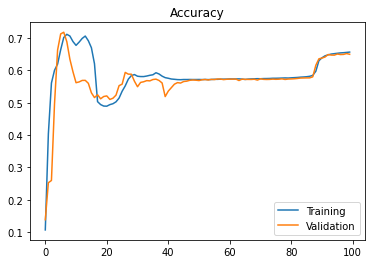

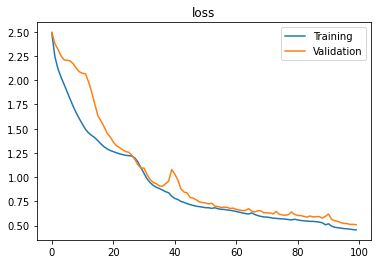

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label = 'Training')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.legend()

plt.figure()
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.title('loss')
plt.legend()

## Visualize Results

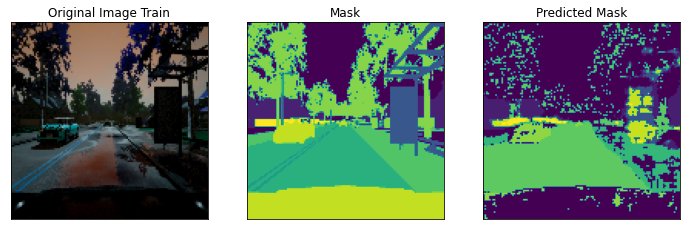

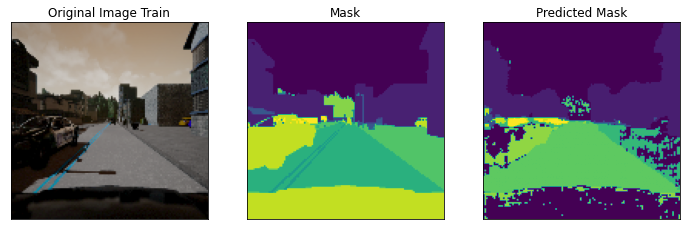

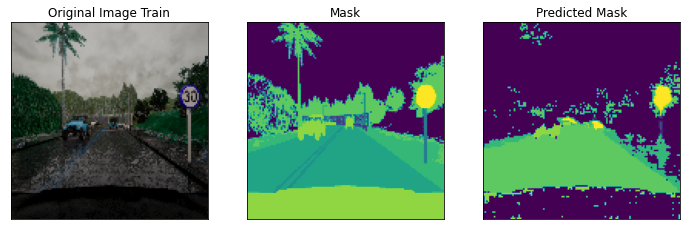

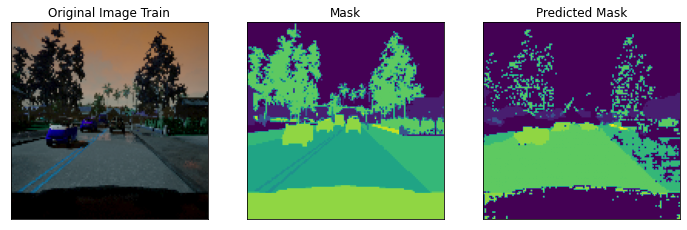

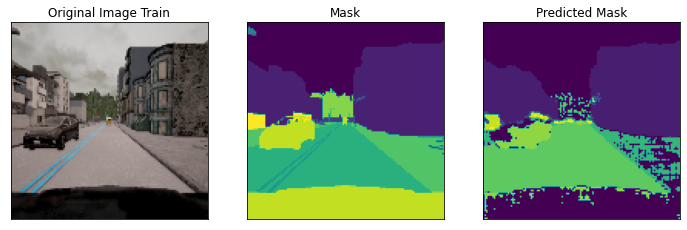

In [ ]:
for idx in range(5):
  idx = np.random.randint(0,len(image_list))  
  preds_train = (model.predict(image_list[idx][None]) > 0.5).astype(np.uint8)
  newimg = np.zeros((preds_train.shape[1], preds_train.shape[2]))

  # format masks
  for i in range(preds_train.shape[3]):
      for j in range(preds_train.shape[1]):
          for k in range(preds_train.shape[2]):
              if preds_train[0,j,k,i] > 0.3:
                newimg[j,k] = i


  fig, axes = plt.subplots(ncols=3, figsize=(12, 12))
  ax1, ax2, ax3 = axes
  ax1.imshow(image_list[idx]);
  #ax1.set_grid(True);
  ax1.set_xticks([]);
  ax1.set_yticks([]);
  ax1.set_title("Original Image Train")

  ax2.imshow(np.squeeze(mask_list[idx]));
  #ax2.set_grid(True);
  ax2.set_xticks([]);
  ax2.set_yticks([])
  ax2.set_title("Mask")


  ax3.imshow(newimg);
  #ax2.set_grid(True);
  ax3.set_xticks([]);
  ax3.set_yticks([])
  ax3.set_title("Predicted Mask");
  plt.show()